In [37]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import requests
import shutil
import time
import zipfile

%matplotlib inline

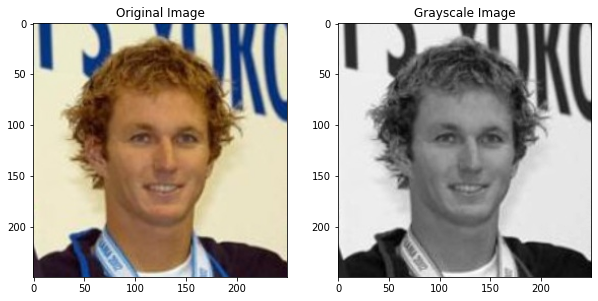

In [38]:
timg_1 = mpimg.imread('/Users/zvele/Desktop/Visión Artificial/Proyecto_Final/Fotos/Aaron_Peirsol_0002.jpg')
timg1_gray = cv2.cvtColor(timg_1, cv2.COLOR_RGB2GRAY)

f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,8))
ax1.set_title('Original Image')
ax1.imshow(timg_1)
ax2.set_title('Grayscale Image')
ax2.imshow(timg1_gray, cmap='gray')

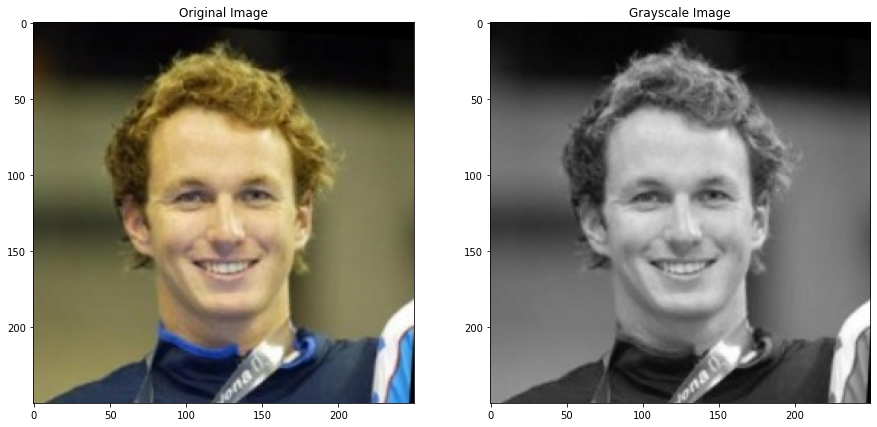

In [39]:
vimage_1 = mpimg.imread('/Users/zvele/Desktop/Visión Artificial/Proyecto_Final/Fotos/Aaron_Peirsol_0003.jpg')
vimg1_gray = cv2.cvtColor(vimage_1, cv2.COLOR_RGB2GRAY)

f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
ax1.set_title('Original Image')
ax1.imshow(vimage_1)
ax2.set_title('Grayscale Image')
ax2.imshow(vimg1_gray, cmap='gray')

In [44]:
def SIFT (image, retimg, grayconv=True):
# retimg = return image | grayconv = image convert to grayscale
    if grayconv:
        gray = image
    else:
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    sift = cv2.xfeatures2d.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(gray, None)
    out = cv2.drawKeypoints(gray,keypoints,gray,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    print('Number of Keypoints found: ', len(keypoints))
    if (retimg):
        return keypoints, descriptors, out
    else:
        return keypoints, descriptors

In [45]:
# function to graph color images
def graph(img_col, titles, x, y=1, cmap = 'viridis'):
  """
  Input:
  img_col = array of images, titles = array of titles (same order than images)
  x = # of columns of image matrix, y = # of rows of image matrix (def=1)
  Output:
  None
  Graphs an image matrix with user defined size, the user sends the images on an 
  array, the images on another array, and the size. For a single row use, the 
  user just sends the column number.
  Use of libraries: matplotlib.pyplot as plt
  """
  f1_1, axes = plt.subplots(y,x, figsize=(15,10)) 
  d = 0
  if (y == 1): 
    if (x == 1):
      axes.set_title(titles[0])
      axes.imshow(img_col[0], cmap=cmap)
    else:
      for i in range(x):
        axes[i].set_title(titles[d])
        axes[i].imshow(img_col[d], cmap=cmap)        
        d = d+1
  else: 
    for i in range(x):
      for j in range(y):
        axes[i][j].set_title(titles[d])
        axes[i][j].imshow(img_col[d], cmap=cmap)
        d = d+1

Number of Keypoints found:  286
Number of Keypoints found:  291


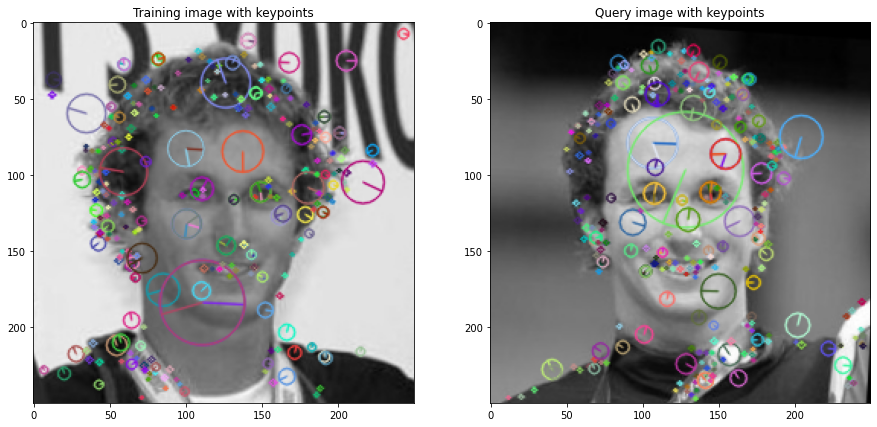

In [48]:
kp1tr,ds1tr,imgtr1 = SIFT(timage_1,True,False)
kp1v,ds1v,imgv1 = SIFT(vimage_1,True,False)
graph([imgtr1, imgv1], ['Training image with keypoints', 'Query image with keypoints'], 2)

In [55]:
bf = cv2.BFMatcher()

matches = bf.knnMatch(ds1tr, ds1v, k=2)
len(matches[0])

2

In [68]:
gm = [] # good matches
for m, n in matches:
    if m.distance < 0.75*n.distance:
        gm.append([m])
print(len(matches))
print(len(gm))

286
8


Not a Match


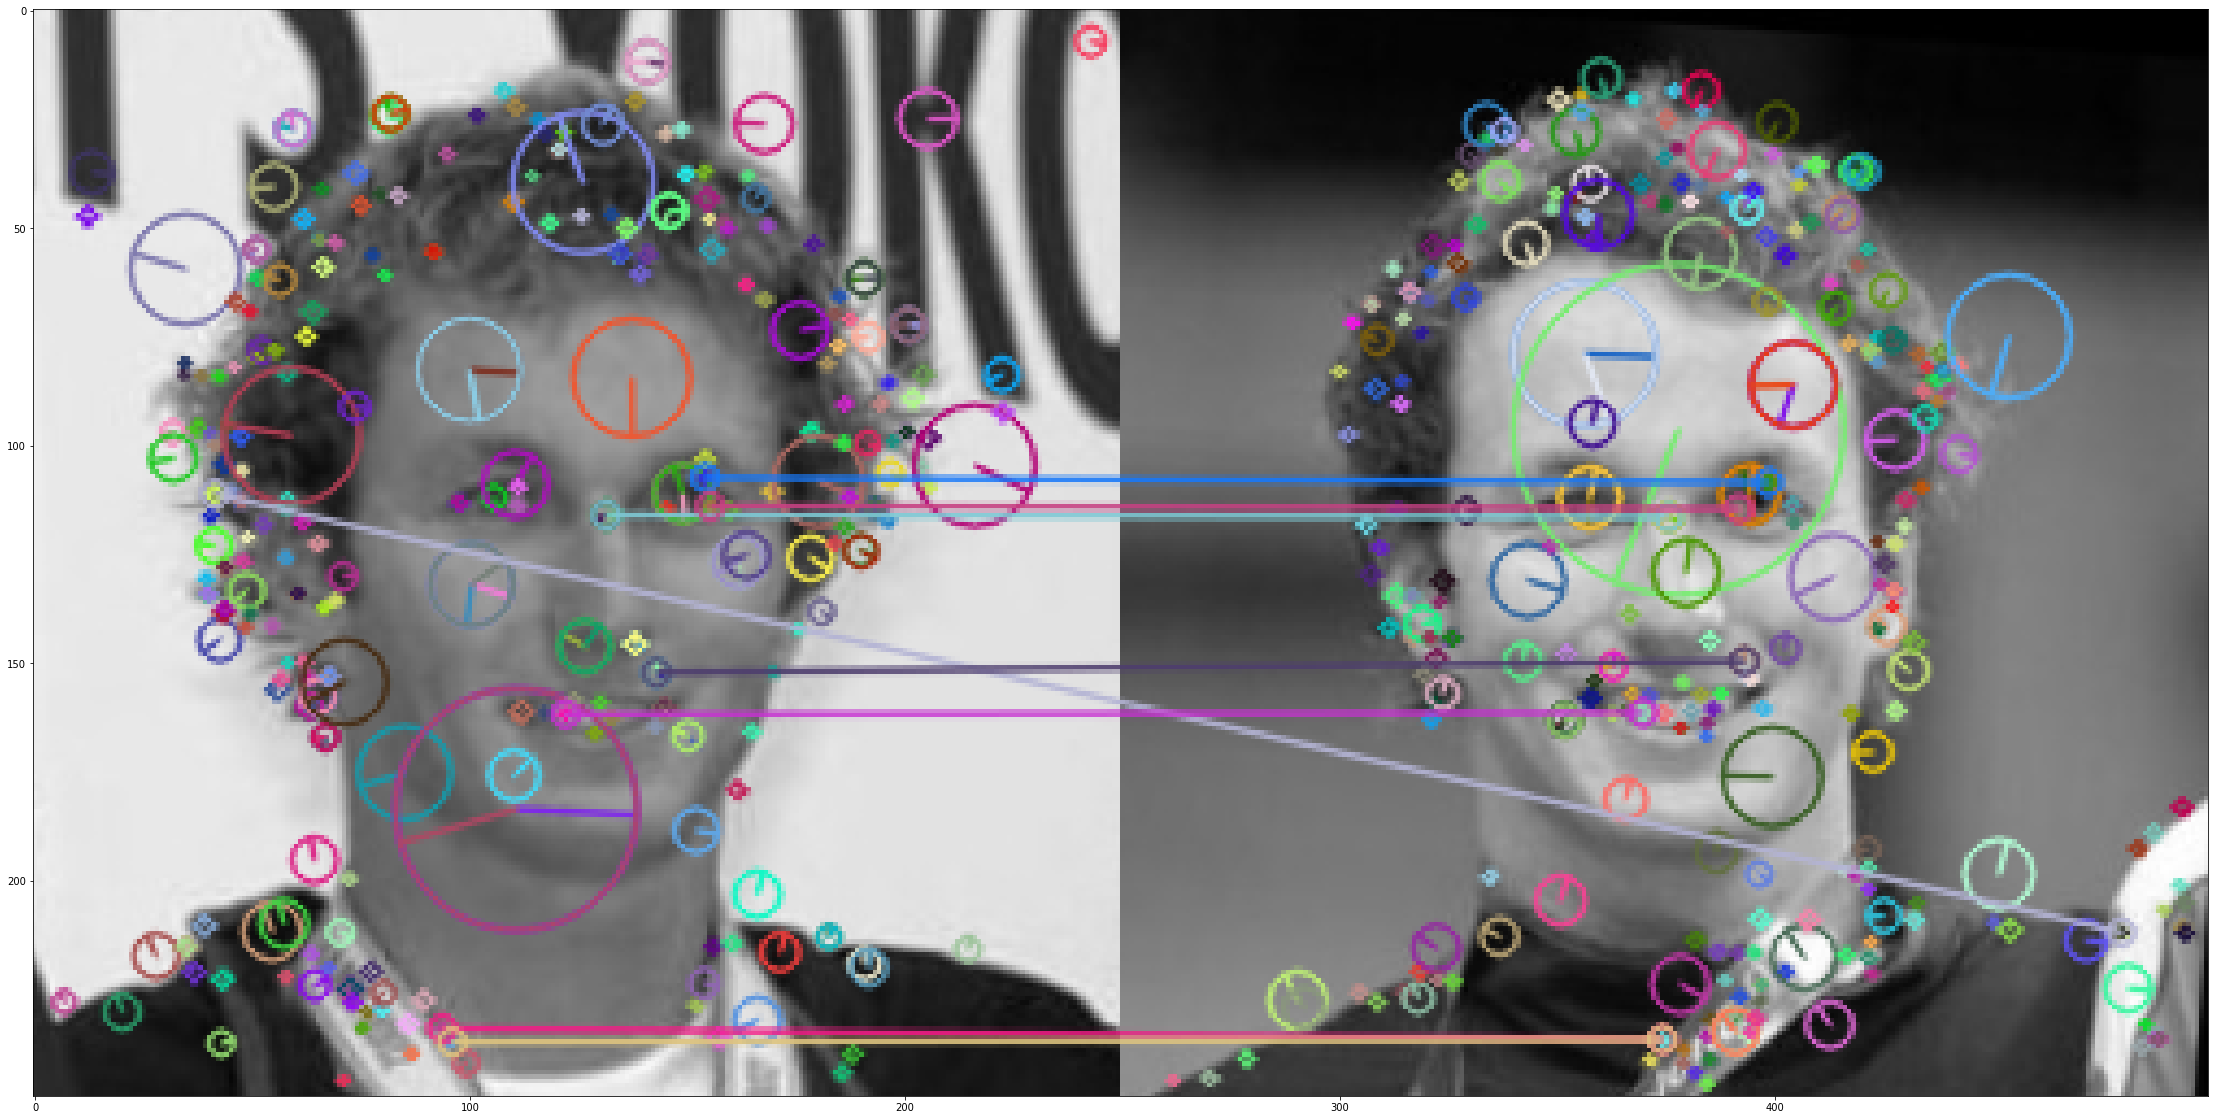

In [69]:
# cv2.drawMatchesKnn expects list of lists as matches.
img3 = cv2.drawMatchesKnn(imgtr1,kp1tr,imgv1,kp1v,gm,None,flags=2)

# decide whether the images are a match or not based on the number of good matches.
# Yes, crude but a good starting intuition
if len(gm)>=45:
  print("It's a Match")

else:
  print("Not a Match")

plt.figure(figsize=(40,20))
plt.imshow(img3)
plt.show()

Number of Keypoints found:  286
Number of Keypoints found:  291
2
286
good matches: 17
Not a Match


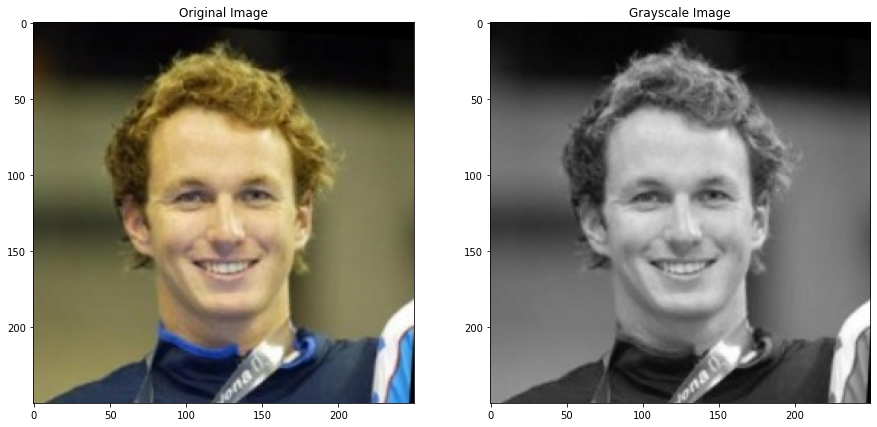

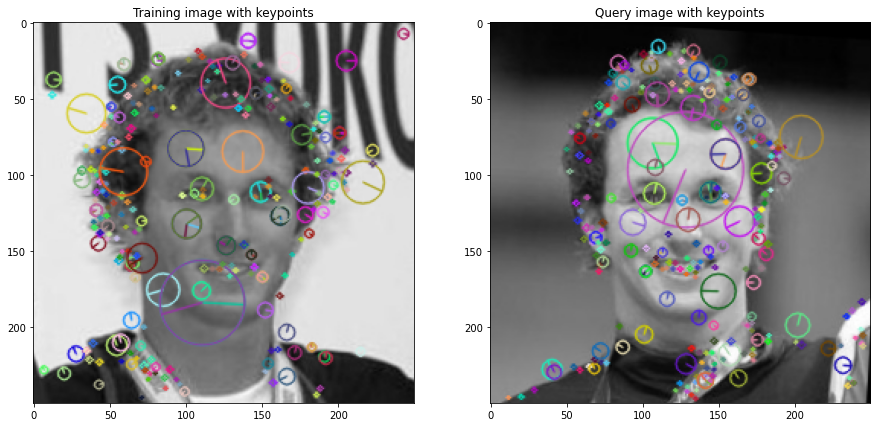

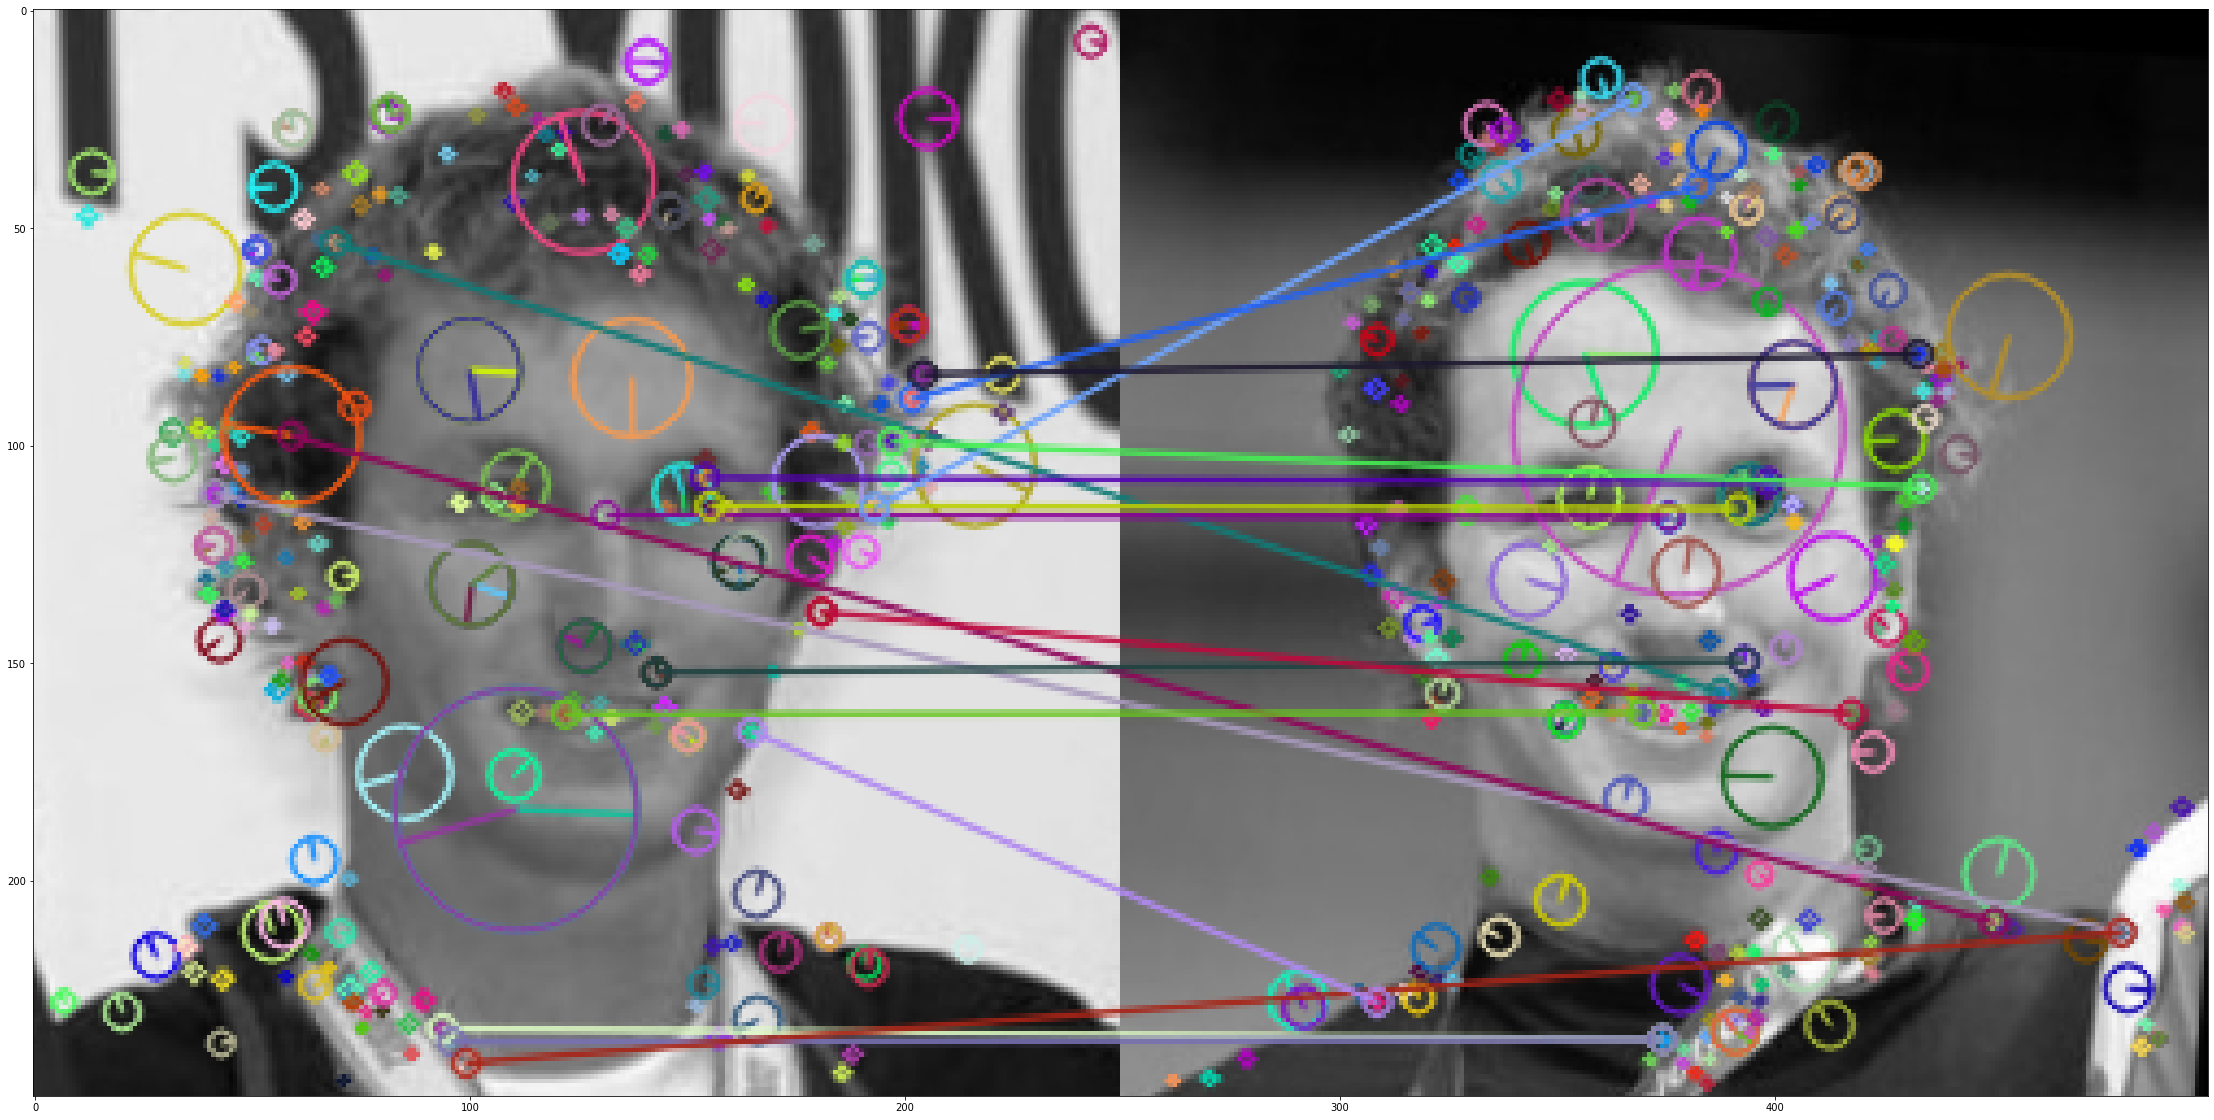

In [81]:
def query(person, thresh=0.8):
    aux = '/Users/zvele/Desktop/Visión Artificial/Proyecto_Final/Fotos/'+person+'.jpg'
    vimg = mpimg.imread(aux)
    vimgray = cv2.cvtColor(vimg, cv2.COLOR_RGB2GRAY)

    f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
    ax1.set_title('Original Image')
    ax1.imshow(vimage_1)
    ax2.set_title('Grayscale Image')
    ax2.imshow(vimg1_gray, cmap='gray')
    
    kp1tr,ds1tr,imgtr1 = SIFT(timage_1,True,False)
    kp1v,ds1v,imgv1 = SIFT(vimage_1,True,False)
    graph([imgtr1, imgv1], ['Training image with keypoints', 'Query image with keypoints'], 2)
    
    bf = cv2.BFMatcher()

    matches = bf.knnMatch(ds1tr, ds1v, k=2)
    print(len(matches[0]))
    
    gm = [] # good matches
    for m, n in matches:
        if m.distance < thresh*n.distance:
            gm.append([m])
    print(len(matches))
    print('good matches: '+str(len(gm)))
    
    # cv2.drawMatchesKnn expects list of lists as matches.
    img3 = cv2.drawMatchesKnn(imgtr1,kp1tr,imgv1,kp1v,gm,None,flags=2)

    # decide whether the images are a match or not based on the number of good matches.
    # Yes, crude but a good starting intuition
    if len(gm)>=45:
      print("It's a Match")

    else:
      print("Not a Match")

    plt.figure(figsize=(40,20))
    plt.imshow(img3)
    plt.show()
    
query('Aaron_Peirsol_0003')

In [70]:
def FLANN(image1,image2,kpv,dsv,kpt,dst,flag):
    index_params = dict(algorithm=1, trees=5)
    search_params = dict(check=50)

    flann = cv2.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(dsv,dst,k=2)
    matchM = [[0,0] for i in range(len(matches))]

    cnt = 0
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.7*n.distance:
            matchM[i]=[1,0]
            cnt+=1

    drawP = dict(matchColor=(0,255,0), singlePointColor=(255,0,0), matchesMask = matchM, flags=cv2.DrawMatchesFlags_DEFAULT)
    out = cv2.drawMatchesKnn(image1,kpv,image2,kpt,matches,None,**drawP)
    if (flag):
        f1, (ax1) = plt.subplots(1, 1, figsize=(10,8))
        ax1.set_title('Matching')
        ax1.imshow(out)

    print('Number of Matches: ', cnt)
    return out

Number of Keypoints found:  291
Number of Matches:  9


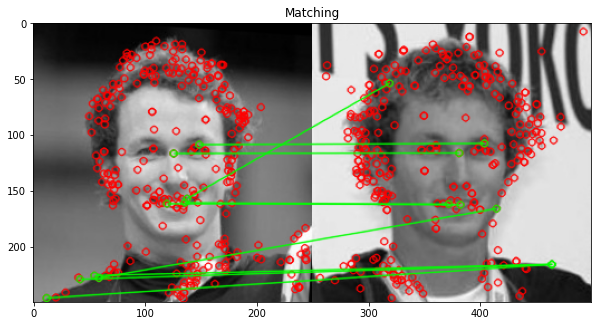

In [71]:
k1v,d1v = SIFT(vimage_1,False,False)
out = FLANN(vimg1_gray,timg1_gray,k1v,d1v,k1tr,d1tr,True)

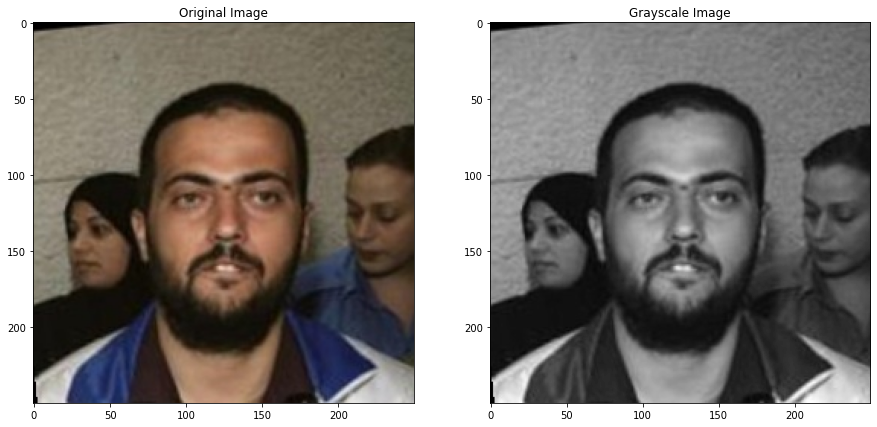

In [18]:
vimage_2 = mpimg.imread('/Users/zvele/Desktop/Visión Artificial/Proyecto_Final/Fotos/Abdel_Nasser_Assidi_0001.jpg')
vimg2_gray = cv2.cvtColor(vimage_2, cv2.COLOR_RGB2GRAY)

f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
ax1.set_title('Original Image')
ax1.imshow(vimage_2)
ax2.set_title('Grayscale Image')
ax2.imshow(vimg2_gray, cmap='gray')

Number of Keypoints found:  199
Number of Matches:  3


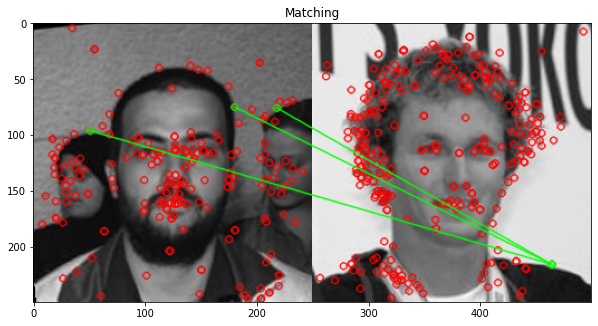

In [19]:
k2v,d2v = SIFT(vimage_2,False,False)
out = FLANN(vimg2_gray,timg1_gray,k2v,d2v,k1tr,d1tr,True)

In [31]:
def BF1(image1,image2,kpv,dsv,kpt,dst,flag):
    bf = cv2.BFMatcher()
    matches = bf.match(dst, dsv)
    matches  = sorted(matches, key = lambda x : x.distance)
    #out = cv2.drawMatches(image1,kpv,image2,kpt,matches[:100],image2,flags=2)
    if (flag):
        f1, (ax1) = plt.subplots(1, 1, figsize=(10,8))
        ax1.set_title('Matching')
        ax1.imshow(out)

    print('Number of Matches: ', len(matches))
    return out

In [33]:
out = BF1(vimg1_gray,timg1_gray,k2v,d2v,k1tr,d1tr,False)

Number of Matches:  286


In [34]:
out = BF1(vimg2_gray,timg1_gray,k2v,d2v,k1tr,d1tr,False)

Number of Matches:  286


In [ ]:

vimage_2 = mpimg.imread('/Users/zvele/Desktop/Visión Artificial/Proyecto_Final/Fotos/Abdel_Nasser_Assidi_0001.jpg')
vimg2_gray = cv2.cvtColor(vimage_2, cv2.COLOR_RGB2GRAY)

f1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
ax1.set_title('Original Image')
ax1.imshow(vimage_2)
ax2.set_title('Grayscale Image')
ax2.imshow(vimg2_gray, cmap='gray')

k2v,d2v = SIFT(vimage_2,False,False)
out = FLANN(vimg2_gray,timg1_gray,k2v,d2v,k1tr,d1tr,True)